In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%pwd
%cd ~/Desktop/whynot

/Users/smruthi/Desktop/whynot


In [8]:
%load_ext autoreload
%autoreload 2
from itertools import product

import matplotlib.pyplot as plt
import numpy as np

# import whynot as wn
import whynot.gym as gym

from scripts import utils

%matplotlib inline
import whynot.simulators.covid19 as covid19
import tensorflow.compat.v1 as tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
env = gym.make('COVID19-v0')
env.seed(1);


In [10]:
class NoTreatmentPolicy():
    def sample_action(self, obs):
        return 0
    
class SocialDistancingPolicy():
    def __init__(self, social_distance_val):
        self.social_distance_val = social_distance_val
        
    def sample_action(self, obs):
        # return np.array([self.social_distance_val])
        return self.social_distance_val
# class ActorCriticPolicy():
#     def __init__(self):
#         with tf.Session() as self.sess:    
#             saver = tf.train.import_meta_graph('my-test-model.meta')
#             saver.restore(self.sess,tf.train.latest_checkpoint('./'))

#     def sample_action(self,obs):
#         action = self.sess.run(action_tf_var, feed_dict={state_placeholder: scale_state(state)})[0]
#         return (np.array([action, 1.0, 1.0]), np.array([0.3, 0.1, 0.95]))

*****Iteration 0*****
*****Iteration 10*****
*****Iteration 20*****
*****Iteration 30*****
*****Iteration 40*****
*****Iteration 50*****
*****Iteration 60*****
*****Iteration 70*****
*****Iteration 80*****
*****Iteration 90*****
*****Iteration 100*****
*****Iteration 110*****
*****Iteration 120*****
*****Iteration 130*****
*****Iteration 140*****
*****Iteration 150*****
*****Iteration 160*****
*****Iteration 170*****
*****Iteration 180*****
*****Iteration 190*****
*****Iteration 200*****
*****Iteration 210*****
*****Iteration 220*****
*****Iteration 230*****
*****Iteration 240*****
*****Iteration 250*****
*****Iteration 260*****
*****Iteration 270*****
*****Iteration 280*****
*****Iteration 290*****


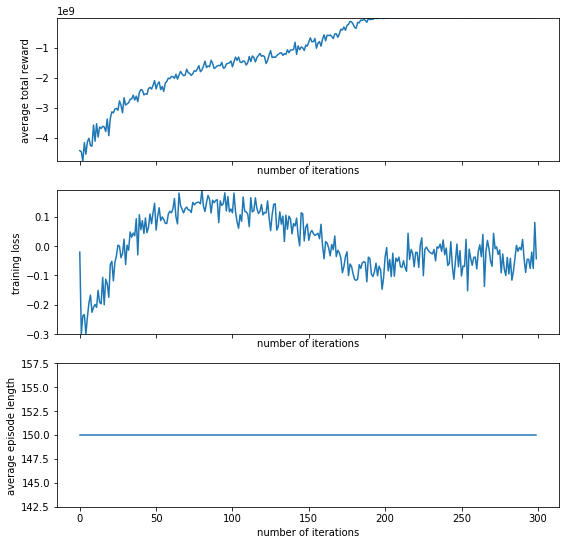

In [11]:
learned_policy = utils.run_training_loop(
    env=env, n_iter=300, max_episode_length=150, batch_size=1000, learning_rate=1e-3)

In [12]:
policies = {
    "No Treatment": NoTreatmentPolicy(),
    "Social Distance 10%": SocialDistancingPolicy(0),
    "Social Distance 25%": SocialDistancingPolicy(1),
    "Social Distance 50%": SocialDistancingPolicy(2),
    "Social Distance 100%": SocialDistancingPolicy(3),
    "learned_policy": learned_policy,
}

In [13]:
def sample_trajectory(env, policy, max_episode_length):
    """Sample a single trajectory, acting according to the specified policy."""
    # initialize env for the beginning of a new rollout
    ob = env.reset()
    obs, acs, rewards, next_obs, terminals = [], [], [], [], []
    steps = 0
    while True:
        # Use the most recent observation to decide what to do
        obs.append(ob)
        ac = policy.sample_action(ob)
        acs.append(ac)

        # Take that action and record results
        ob, rew, done, _ = env.step(ac)

        # Record result of taking that action
        steps += 1
        next_obs.append(ob)
        rewards.append(rew)

        # End the rollout if the rollout ended
        # Note that the rollout can end due to done, or due to max_episode_length
        if done or steps > max_episode_length:
            rollout_done = 1
        else:
            rollout_done = 0
        terminals.append(rollout_done)
        if rollout_done:
            break

    return {"observation" : np.array(obs, dtype=np.float32),
            "reward" : np.array(rewards, dtype=np.float32),
            "action" : np.array(acs, dtype=np.float32),
            "next_observation": np.array(next_obs, dtype=np.float32),
            "terminal": np.array(terminals, dtype=np.float32)}

In [14]:
def plot_sample_trajectory(policies):
    """Plot sample trajectories from policies."""
    obs_dim_names = covid19.State.variable_names()

    fig, axes = plt.subplots(5, 2, sharex=True, figsize=[25, 15])
    axes = axes.flatten()

    action_to_intervention_map = {
        0: 0.9,
        1: 0.75,
        2: 0.5,
        3: 0.0,
        4: 0.1,
        5: 0.25,
        6: 0.5,
        7: 0.75,
        8: 0.25,
        9: 0.5,
        10: 0.75,
        11: 0.99
    }

    for name, policy in policies.items():
        trajectory = sample_trajectory(env, policy, 400)
        obs = trajectory["observation"]
        # Plot state evolution
        for i in range(len(obs_dim_names)):
            y = obs[:, i]
            axes[i].plot(y, label=name)
            axes[i].set_ylabel(obs_dim_names[i])
            ymin, ymax = axes[i].get_ylim()
            axes[i].set_ylim(np.minimum(ymin, y.min()), np.maximum(ymax, y.max()))
            ymin, ymax = axes[i].get_ylim()
        
        # Plot actions
        # scale_actions, probability_actions = np.split(trajectory["action"], 2, axis=1)
        actions = np.array(trajectory["action"])
        # print(actions)
        actionlist_beta = []
        actionlist_hosp = []
        actionlist_rec = []
        for action in actions:
            if action < 3:
                actionlist_beta.append(action_to_intervention_map[action])
                actionlist_hosp.append(.3)
                actionlist_rec.append(0.95)
            elif action < 8:
                actionlist_hosp.append(action_to_intervention_map[action])
                actionlist_beta.append(1.)
                actionlist_rec.append(0.95)
            else:
                actionlist_rec.append(action_to_intervention_map[action])
                actionlist_beta.append(1.)
                actionlist_hosp.append(.3)
            
        actionlist = [actionlist_beta,actionlist_hosp,actionlist_rec]
        for idx, label in enumerate(["beta_scale", "proportion_hospitalized", "proportion_recovered_after_hospitalization"]):
            ax_idx = len(obs_dim_names) + idx
            axes[ax_idx].plot(actionlist[idx], label=name)
            # axes[ax_idx].plot(,label=name)
            axes[ax_idx].set_ylabel(label)
        
        # Plot reward
        reward = trajectory["reward"]
        axes[-1].plot(reward, label=name)
        axes[-1].set_ylabel("reward")
        axes[-1].ticklabel_format(scilimits=(-2, 2))
        ymin, ymax = axes[-1].get_ylim()
        axes[-1].set_ylim(np.minimum(ymin, reward.min()), np.maximum(ymax, reward.max()))
    
        print(f"Total reward for {name}: {np.sum(reward):.2f}")
        
    for ax in axes:
        ax.legend()
        ax.set_xlabel("Day")
    plt.subplots_adjust(hspace=0.4)
    plt.show()

Total reward for No Treatment: -2465330688.00
Total reward for Social Distance 10%: -2465330688.00
Total reward for Social Distance 25%: -2181158912.00
Total reward for Social Distance 50%: -1129204224.00
Total reward for Social Distance 100%: -685321.88
Total reward for learned_policy: -1249479.50


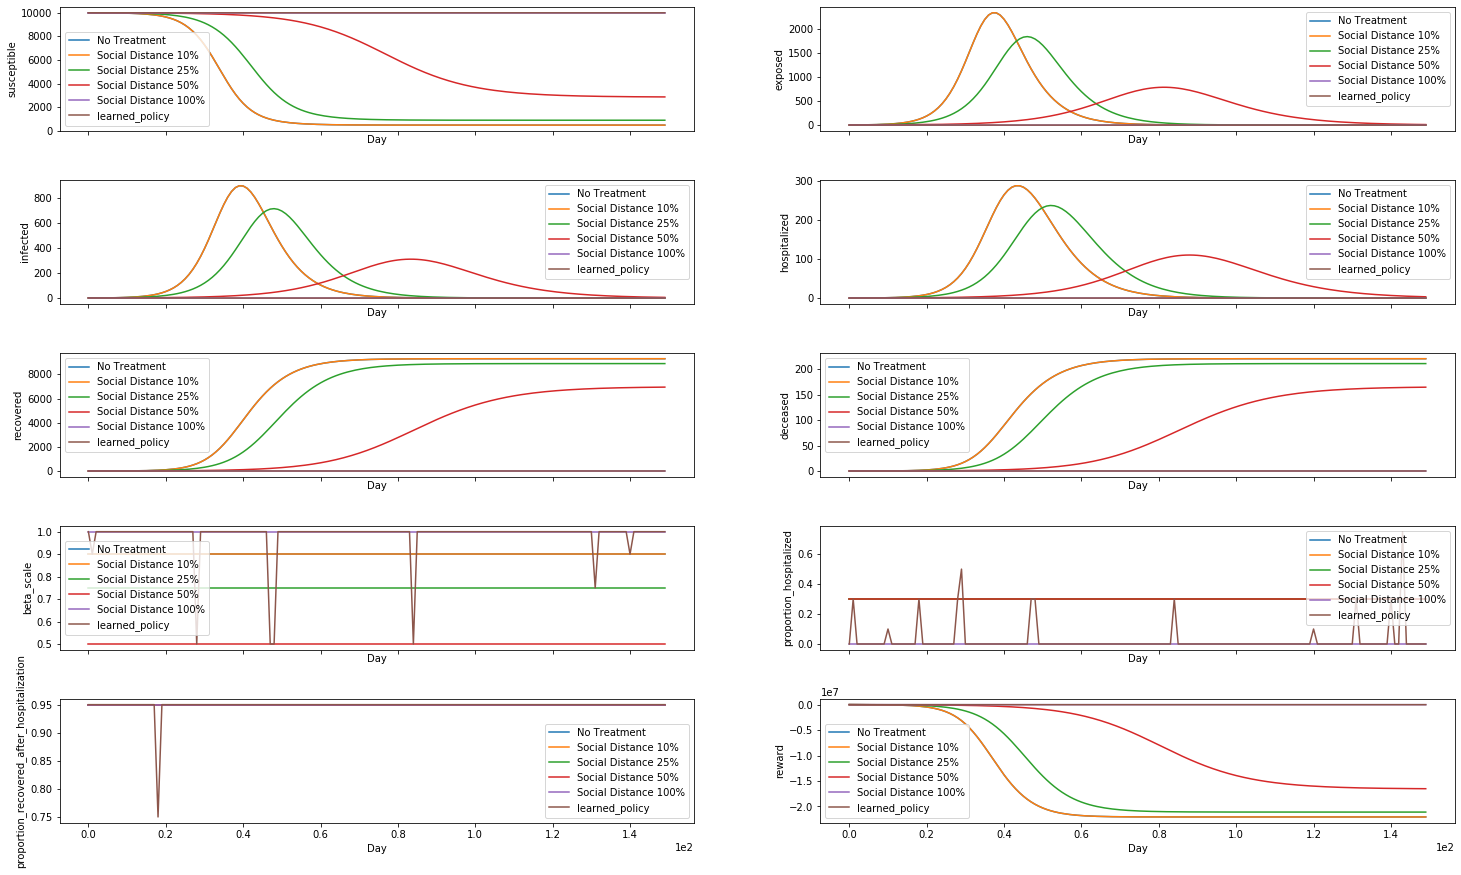

In [15]:
plot_sample_trajectory(policies)

References:

1. https://wwwnc.cdc.gov/eid/article/26/6/20-0233_article
2. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6332839/